In [4]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import Qobj, basis, mesolve, tensor, qeye, sigmaz
from joblib import Parallel, delayed

In [5]:
t_max = 50*np.pi
delta = 0
omega_max = 1
num_points = 500

times = np.linspace(0, t_max, num_points)
gammas = np.linspace(0, 0.5, num_points//10)

In [6]:
def omega(t, omega_max, t_max, sign=1):
    # sign=1 -> second pulse
    # sing=-1 -> first pulse
    
    sigma = t_max / 8
    return omega_max * np.exp(-(t - (t_max/2 + sign*sigma / 2))**2 / (2*sigma**2))

def omega_12g(t, omega_max, t_max):
    return omega(t, omega_max, t_max)

def omega_23g(t, omega_max, t_max):
    return omega(t, omega_max, t_max, -1)

Text(0, 0.5, 'pulses')

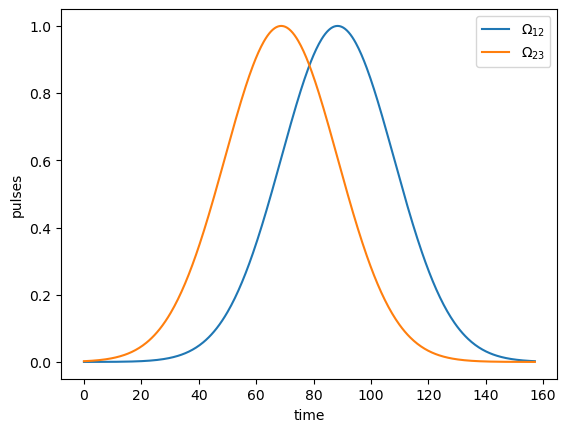

In [10]:
fig, ax = plt.subplots()

ax.plot(times, omega_12g(times, omega_max, t_max), label=r'$\Omega_{12}$')
ax.plot(times, omega_23g(times, omega_max, t_max), label=r'$\Omega_{23}$')

ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('pulses')

In [11]:
def solvePopulations(times, gamma, t_max, delta, omega_12g, omega_23g, omega_max):
    psi0 = basis(3, 0)

    if t_max == 0:
        return np.abs(np.array([psi0])) ** 2

    c1 = np.array([1, -1, 0])*np.sqrt(gamma)
    collapse_op1 = Qobj(np.diag(c1))
    c2 = np.array([1, 1, -2])*np.sqrt(gamma/3)
    collapse_op2 = Qobj(np.diag(c2))

    H0 = Qobj([[0, 0, 0], [0, delta, 0], [0, 0, 0]])
    H12 = Qobj([[0, -1, 0], [-1, 0, 0], [0, 0, 0]])
    H23 = Qobj([[0, 0, 0], [0, 0, -1], [0, -1, 0]])

    H = [H0, [H12, omega_12g(times, omega_max, t_max)], [H23, omega_23g(times, omega_max, t_max)]]

    result = mesolve(H, psi0, times, [collapse_op1, collapse_op2])

    result = np.array(result.states)

    return np.array([result[:,0,0], result[:,1,1], result[:,2,2]]).T

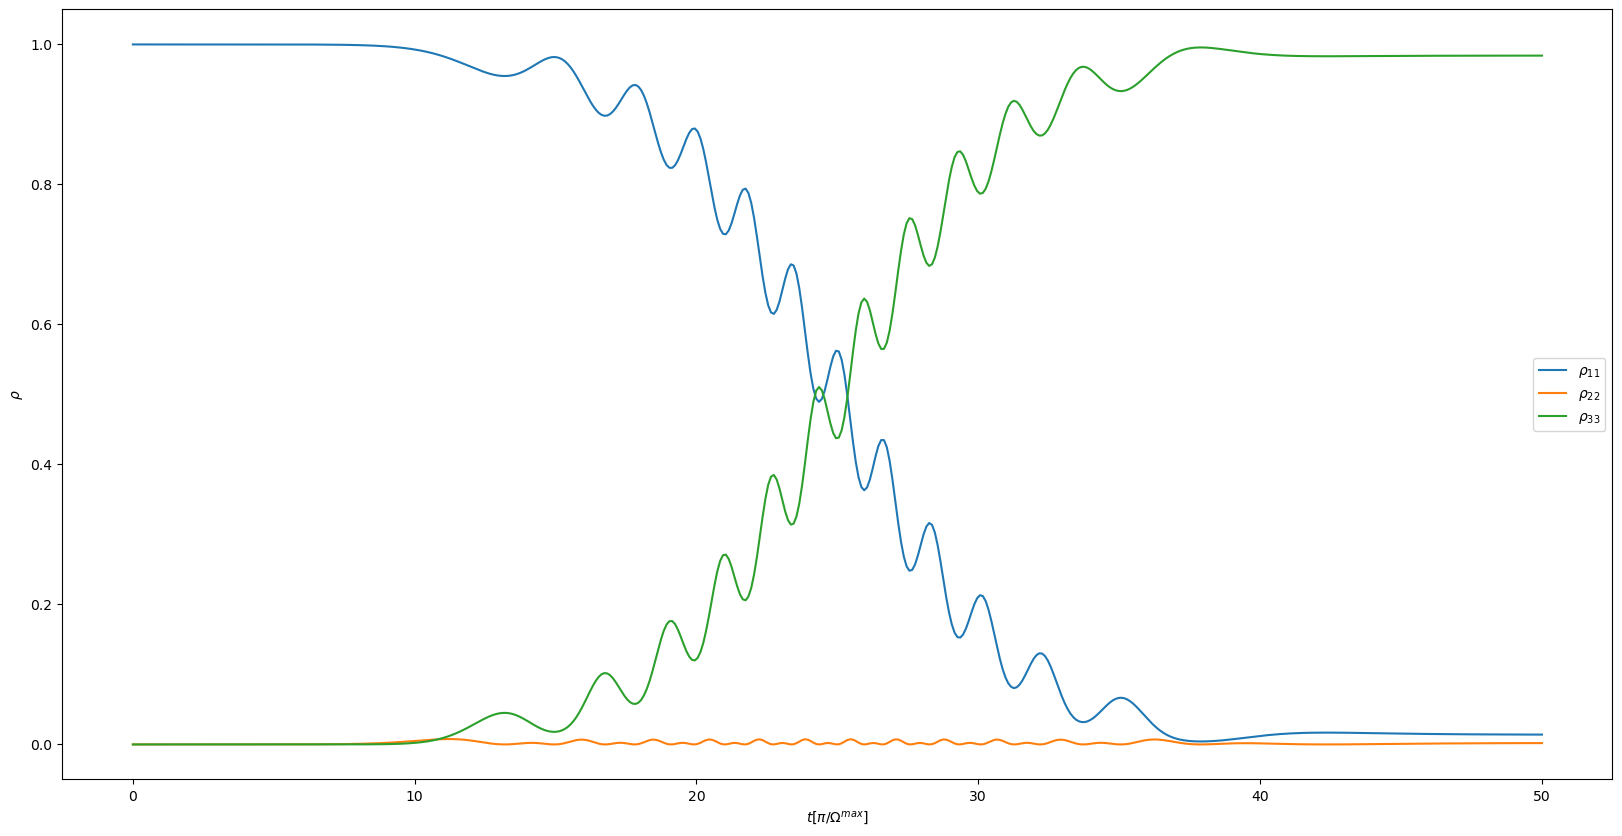

In [12]:
gamma = 0

population = solvePopulations(times, gamma, t_max, delta, omega_12g, omega_23g, omega_max)

fig, ax = plt.subplots(1, figsize=(20,10))

plt.plot(times/(np.pi/omega_max), np.real(population[:,0]), label=r'$\rho_{11}$')
plt.plot(times/(np.pi/omega_max), np.real(population[:,1]), label=r'$\rho_{22}$')
plt.plot(times/(np.pi/omega_max), np.real(population[:,2]), label=r'$\rho_{33}$')
plt.xlabel(r'$t[\pi/\Omega^{max}]$') 
plt.ylabel(r'$\rho$')
plt.legend()

In [13]:
def solveLastPopulationsTmax(times, gamma, t_max_tot, num_points, delta, omega_12g, omega_23g, omega_max):
    result = np.array([])
    for t in times:
        times_p = np.linspace(0, t, num_points)
        result = np.append(result, solvePopulations(times_p, gamma, t, delta, omega_12g, omega_23g, omega_max)[-1])
    return result.reshape((len(times), 3))

In [14]:
populations_gamma_t_max_int = np.array(Parallel(n_jobs=-1)(delayed(solveLastPopulationsTmax)(times, gamma, t_max, num_points, delta, omega_12g, omega_23g, omega_max) for gamma in gammas))

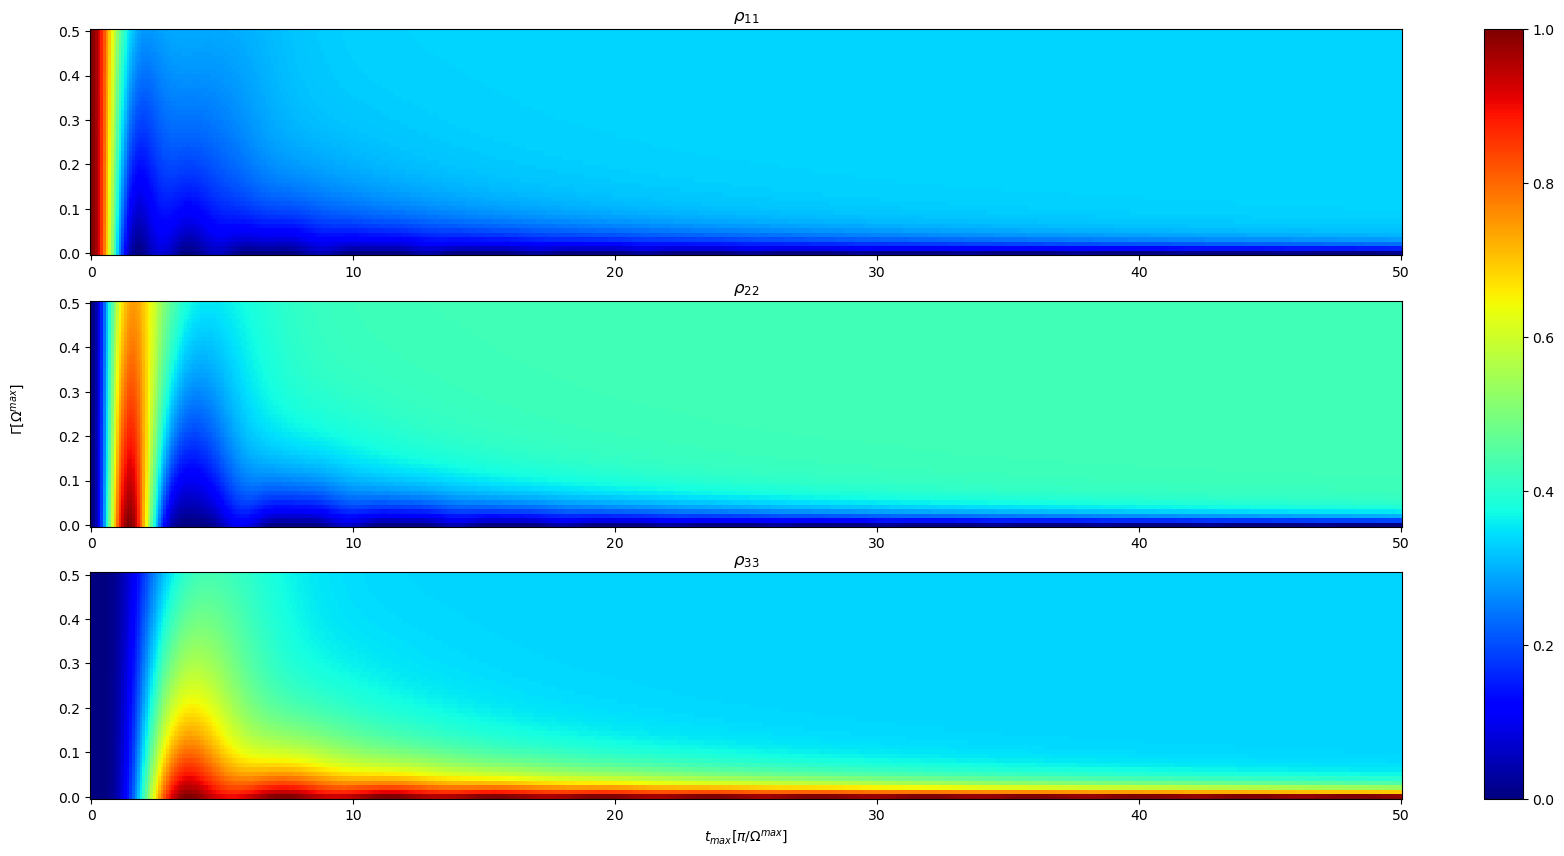

In [16]:
T, G = np.meshgrid(times/(np.pi/omega_max), gammas/omega_max)

fig, ax = plt.subplots(3, 1, figsize=(20,10))

cmap = 'jet'
im1 = ax[0].pcolormesh(T, G, np.real(populations_gamma_t_max_int[:,:,0]), cmap=cmap)
ax[0].set_title(r'$\rho_{11}$')
ax[1].pcolormesh(T, G, np.real(populations_gamma_t_max_int[:,:,1]), cmap=cmap)
ax[1].set_title(r'$\rho_{22}$')
ax[2].pcolormesh(T, G, np.real(populations_gamma_t_max_int[:,:,2]), cmap=cmap)
ax[2].set_title(r'$\rho_{33}$')

plt.xlabel(r'$t_{max}[\pi/\Omega^{max}]$')
fig.text(0.04, 0.5, r'$\Gamma[\Omega^{max}]$', va='center', rotation='vertical')

plt.subplots_adjust(left=0.08)
fig.colorbar(im1, ax=ax.ravel().tolist())

plt.show()